In [36]:
from sentence_transformers import SentenceTransformer
import random
import nltk
import dspy
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import pipeline
import re
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
from collections import defaultdict
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import matplotlib.cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from sklearn.preprocessing import normalize
from sklearn.metrics import ndcg_score
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib
import os
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def create_category_string(category, dictionary):
    string = f"{category}: "

    if category in dictionary:
        category_data = dictionary[category]
        if isinstance(category_data, list):
            for item in category_data:
                for k, v in item.items():
                    if k == 'name':
                        continue
                    if isinstance(v, list):
                        v = ', '.join(v)
                    string += f"{k}: {v} "
        elif isinstance(category_data, dict):
            for k, v in category_data.items():
                if k == 'name':
                    continue
                if isinstance(v, list):
                    v = ', '.join(v)
                string += f"{k}: {v} "
        else:
            string += f"{category}: {category_data} "

    return string.strip()


def transform_dict_to_strings(data):
    result = {}

    for category in data:
        result[category] = create_category_string(category, data)

    return result


In [37]:
class CharacterAnonymizer:
    def __init__(self, batch_size=16):
        self.ner_pipeline = pipeline(
            "ner",
            model="Jean-Baptiste/roberta-large-ner-english",
            aggregation_strategy="simple",
            device=0
        )
        self.batch_size = batch_size

    def normalize_name(self, name):
        name = name.lower()
        name = re.sub(r"[^a-z ]", "", name)
        return name.strip()

    def extract_names_batch(self, texts):
        ner_results_batch = self.ner_pipeline(texts)
        all_names = []
        for ner_results in ner_results_batch:
            names = [ent['word'] for ent in ner_results if ent['entity_group'] == 'PER']
            normalized = list(set(self.normalize_name(name) for name in names))
            all_names.append(normalized)
        return all_names

    def cluster_names(self, names):
        clusters = defaultdict(list)
        used = set()

        for name in names:
            if not name.strip():
                continue
            if name in used:
                continue
            parts = name.split()
            if not parts:
                continue
            key = parts[0]
            for other in names:
                if key in other and other not in used:
                    clusters[key].append(other)
                    used.add(other)
        return clusters

    def generate_name_map(self, clusters):
        name_map = {}
        for i, (key, variants) in enumerate(clusters.items(), start=1):
            tag = f"Character{i}"
            for name in variants:
                name_map[name] = tag
        return name_map

    def replace_names(self, text, name_map):
        for original in sorted(name_map.keys(), key=len, reverse=True):
            pattern = re.compile(rf'\b{re.escape(original)}\b', re.IGNORECASE)
            text = pattern.sub(name_map[original], text)
        return text

    def anonymize_batch(self, texts):
        anonymized_texts = []

        for i in tqdm(range(0, len(texts), self.batch_size), desc="Anonymizing"):
            batch = texts[i:i + self.batch_size]
            all_names = self.extract_names_batch(batch)

            for text, names in zip(batch, all_names):
                clusters = self.cluster_names(names)
                name_map = self.generate_name_map(clusters)
                anonymized = self.replace_names(text, name_map)
                anonymized_texts.append(anonymized)

        return anonymized_texts


In [18]:
def build_index(embeddings, normalize_vectors=True):
    if normalize_vectors:
        return normalize(embeddings, axis=1)
    return embeddings


def get_dense_similarity(query_vector, candidate_vectors):
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1, -1)
    return np.dot(candidate_vectors, query_vector.T).flatten()

def get_relevance_scores(i, labels, index):
    matching_label = labels[i]

    query_vector = index[i].reshape(1, -1)
    similarities = get_dense_similarity(query_vector, index).flatten()

    relevance_scores = np.array([1 if x == matching_label else 0 for x in labels])
    similarity_scores = similarities

    mask = np.arange(len(labels)) != i

    relevance_scores = relevance_scores[mask]
    similarity_scores = similarity_scores[mask]

    return relevance_scores.tolist(), similarity_scores.tolist()


def calculate_mean_ndcg_score(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    scores = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)
        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)
        #k = relevance_scores.sum()
        k = None
        scores.append(ndcg_score([relevance_scores], [similarity_scores], k=k))

    return np.mean(scores)


def calculate_mean_recall(labels, embeddings):
    embeddings = np.array(embeddings).astype('float32')
    index = build_index(embeddings)

    recalls = []

    for i in range(len(labels)):
        relevance_scores, similarity_scores = get_relevance_scores(i, labels, index)

        relevance_scores = np.array(relevance_scores)
        similarity_scores = np.array(similarity_scores)

        k = relevance_scores.sum()
        if k == 0:
            continue

        sorted_indices = np.argsort(-similarity_scores)

        top_k_indices = sorted_indices[:k]

        top_k_relevance = relevance_scores[top_k_indices]

        recall = top_k_relevance.sum() / k
        recalls.append(recall)

    if len(recalls) == 0:
        return 0.0
    return np.mean(recalls)





In [41]:
def min_max_scale(arr):
    arr = np.array(arr)
    min_val = arr.min()
    max_val = arr.max()
    if max_val == min_val:
        return np.zeros_like(arr)
    return (arr - min_val) / (max_val - min_val)


def get_dense_similarity(query_vec, matrix):
    query_vec = np.array(query_vec).reshape(1, -1)
    return cosine_similarity(query_vec, matrix)[0]



def transform_dict_to_strings(d):
    return {k: ' '.join(str(vv) for vv in v) if isinstance(v, list) else str(v) for k, v in d.items()}


def get_similarity_scores_from_embeddings(df, index, keys):
    keys.append("overall")
    similarities_by_key = {}

    for key in keys:
        embeddings = np.stack(df[f'embedding_{key}'].values)
        target_embedding = embeddings[index]
        similarities = get_dense_similarity(target_embedding, embeddings)
        similarities_by_key[key] = min_max_scale(similarities)

    all_similarities = np.zeros_like(next(iter(similarities_by_key.values())))

    return similarities_by_key


def make_spider(df, plot_idx, title, color, total_plots, overall_score, plots_per_row=5):
    categories = list(df.columns)[1:]
    if 'overall' in categories:
        categories.remove('overall')
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    row_idx = plot_idx // plots_per_row
    col_idx = plot_idx % plots_per_row
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row
    n_cols = min(plots_per_row, total_plots)

    ax = plt.subplot(n_rows, n_cols, plot_idx + 1, polar=True)
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    plt.xticks(angles[:-1], categories, color='grey', size=8)
    ax.set_rlabel_position(0)
    plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ["0", "0.2", "0.4", "0.6", "0.8", "1"], color="grey", size=7)
    plt.ylim(0, 1)

    values = df.loc[plot_idx, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    wrapped_title = "\n".join(title[i:i + 20] for i in range(0, len(title), 20))
    plt.title(wrapped_title, size=18, color=color, y=1.08)

    ax.text(0.5, 0.5, f"{overall_score:.2f}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center',
            fontsize=24, fontweight='bold', color=color)


def visualize_similarities(df, model, target_index, top_n=4, plots_per_row=5, ascending=False):
    embedding_cols = [col for col in df.columns if col.startswith("embedding_")]
    
    if not embedding_cols:
        df, keys = embed_elements(df, model)
    else:
        keys = [col.replace("embedding_", "") for col in embedding_cols if col != "embedding_overall"]
    similarities_by_key = get_similarity_scores_from_embeddings(df, index=target_index, keys=keys)

    overall_similarities = similarities_by_key["overall"]
    sorted_indices = np.argsort(overall_similarities)
    if not ascending:
        sorted_indices = sorted_indices[::-1]
    sorted_indices = [i for i in sorted_indices if i != target_index][:top_n]

    rows = []
    for i in sorted_indices:
        title = f"{df.iloc[i]['title']} ({df.iloc[i]['language']})"
        data_row = {'group': title}
        for key in keys:
            data_row[key] = similarities_by_key[key][i]
        data_row['overall'] = overall_similarities[i]
        rows.append(data_row)

    query_title = f"{df.iloc[target_index]['title']} ({df.iloc[target_index]['language']})"
    query_row = {'group': f"Query: {query_title}"}
    for key in keys:
        query_row[key] = similarities_by_key[key][target_index]
    query_row['overall'] = overall_similarities[target_index]
    rows.insert(0, query_row)

    plot_data = pd.DataFrame(rows)

    my_dpi = 96
    width_per_plot = 500
    height_per_plot = 500
    total_plots = len(plot_data.index)
    n_rows = (total_plots + plots_per_row - 1) // plots_per_row

    fig_width = width_per_plot * min(plots_per_row, total_plots) / my_dpi
    fig_height = height_per_plot * n_rows / my_dpi

    plt.figure(figsize=(fig_width, fig_height), dpi=my_dpi)
    base_titles = plot_data['group'].apply(lambda x: x.replace('Query: ', '').split(' (')[0])
    unique_titles = base_titles.unique()
    title_to_color_idx = {title: i for i, title in enumerate(unique_titles)}
    my_palette = matplotlib.colormaps["tab20"]

    for plot_idx in range(total_plots):
        base_title = base_titles.iloc[plot_idx]
        color = my_palette(title_to_color_idx[base_title])
        make_spider(df=plot_data, plot_idx=plot_idx, title=plot_data['group'][plot_idx],
                    color=color, total_plots=total_plots,
                    overall_score=plot_data.loc[plot_idx, 'overall'],
                    plots_per_row=plots_per_row)

    plt.tight_layout()
    plt.show()



In [20]:
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

def embed_elements(df, model):
    transformed_data = []
    key_set = set()

    for row in df.itertuples(index=False):
        element = json.loads(row.extracted_elements)
        element['full_summary'] = row.unpacked_summary
        transformed = transform_dict_to_strings(element)
        transformed_data.append(transformed)
        key_set.update(transformed)

    transformed_df = pd.DataFrame(transformed_data)

    embedding_arrays = {}
    for key in key_set:
        texts = transformed_df[key].tolist()
        embeddings = model.encode(texts, show_progress_bar=False)
        normalized_embeddings = normalize(np.array(embeddings), norm='l2')
        df[f'embedding_{key}'] = list(normalized_embeddings)
        embedding_arrays[key] = normalized_embeddings

    all_embeddings = np.stack([embedding_arrays[key] for key in key_set], axis=1)
    mean_embeddings = np.mean(all_embeddings, axis=1)
    df["embedding_overall"] = list(normalize(mean_embeddings, norm='l2'))

    return df, list(key_set)


In [21]:
class SimpleAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim=64, print_weights = False):
        super().__init__()
        self.weights = []
        self.print_weights = print_weights
        self.attention = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, embeddings):
        scores = self.attention(embeddings)  
        weights = torch.softmax(scores, dim=0) 
        if self.print_weights:
            self.weights.append(weights)
            print(torch.stack(self.weights).mean(dim=0))
        return (weights * embeddings).sum(dim=0) 


In [22]:
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, df, embedding_cols, labels):
        self.embedding_data = df[embedding_cols].values
        self.labels = labels

    def __len__(self):
        return len(self.embedding_data)

    def __getitem__(self, idx):
        embeddings = [torch.tensor(e, dtype=torch.float32) for e in self.embedding_data[idx]]
        label = self.labels[idx]
        return torch.stack(embeddings), label


In [23]:
def train_attention(df, embedding_cols, labels, eval_df, eval_labels,
                    epochs=10, batch_size=32, learning_rate=1e-3, margin=1.0):
    
    attention_model = SimpleAttention(len(df[embedding_cols[0]][0]))
    optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        attention_model.train()
        total_loss = 0
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(attention_model(anchor))
                positive_embs.append(attention_model(embeddings_batch[pos_idx]))
                negative_embs.append(attention_model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        avg_train_loss = total_loss / len(dataloader)
        avg_eval_loss = evaluate_attention(attention_model, eval_df, embedding_cols, eval_labels,
                                           batch_size=batch_size, margin=margin)

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.4f} | Eval Loss = {avg_eval_loss:.4f}")

    return attention_model


In [24]:
def evaluate_attention(model, df, embedding_cols, labels, batch_size=32, margin=1.0):
    model.eval()
    criterion = nn.TripletMarginLoss(margin=margin)

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    dataset = EmbeddingDataset(df, embedding_cols, encoded_labels)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch in dataloader:
            embeddings_batch, labels_batch = batch
            anchor_embs, positive_embs, negative_embs = [], [], []

            for i in range(len(labels_batch)):
                anchor = embeddings_batch[i]
                label = labels_batch[i]

                pos_indices = (labels_batch == label).nonzero(as_tuple=True)[0]
                neg_indices = (labels_batch != label).nonzero(as_tuple=True)[0]

                if len(pos_indices) <= 1 or len(neg_indices) == 0:
                    continue

                pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                while pos_idx == i:
                    pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                anchor_embs.append(model(anchor))
                positive_embs.append(model(embeddings_batch[pos_idx]))
                negative_embs.append(model(embeddings_batch[neg_idx]))

            if anchor_embs:
                anchor_embs = torch.stack(anchor_embs)
                positive_embs = torch.stack(positive_embs)
                negative_embs = torch.stack(negative_embs)

                loss = criterion(anchor_embs, positive_embs, negative_embs)
                total_loss += loss.item()
                count += 1

    return total_loss / max(count, 1)


In [25]:
def apply_attention(df, embedding_cols, model):
    df["embedding_overall"] = df[embedding_cols].apply(
        lambda row: model(
            torch.stack([torch.tensor(x, dtype=torch.float32) for x in row])
        ).detach().numpy(),
        axis=1
    )
    return df


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True, device=device)
embedder = dspy.Embedder(model.encode)
df = pd.read_excel("data/tell_me_again_df_with_elements_v6.xlsx")
df = df.dropna()

<All keys matched successfully>


In [ ]:
set_seed(42)
unique_labels = df['label'].unique()

#anonymizer = CharacterAnonymizer(batch_size=16)
#df['extracted_elements'] = anonymizer.anonymize_batch(df['extracted_elements'].tolist())

train_labels, val_labels = train_test_split(
    unique_labels,
    test_size=0.4,
    random_state=42
)

In [104]:
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

if not embedding_cols:
    df, key_set = embed_elements(df, model)
    
df_train = df[df['label'].isin(train_labels)].reset_index(drop=True)
df_val = df[df['label'].isin(val_labels)].reset_index(drop=True)

In [100]:
df

Unnamed: 0  Unnamed: 0.1 wikidata_id              title language  \
0             48            48  Q100265988          Black Box       de   
1             49            49  Q100265988          Black Box       it   
2            128           128  Q100889636  Decision to Leave       de   
3            129           129  Q100889636  Decision to Leave       fr   
4            130           130  Q100889636  Decision to Leave       it   
...          ...           ...         ...                ...      ...   
4071       83188         83188   Q99688807                Old       fr   
4072       83189         83189   Q99688807                Old       it   
4073       83190         83190   Q99688807                Old       es   
4074       83215         83215     Q997671              Three       de   
4075       83222         83223   Q99795824          The Swarm       de   

                                       unpacked_summary  \
0     In a car accident, young mother Rachel is kill...   
1     Nolan is a man who suffers from severe amnesia...   
2     The experienced Commissioner Jang Hae-joon is ...   
3     Hae-joon, a police officer working in Busan, i...   
4     Detective Jang Hae-jun, who suffers from insom...   
...                                                 ...   
4071  A family on vacation discovers that the seclud...   
4072  Guy and Prisca Cappa, husband and wife, travel...   
4073  Married couple Guy and Prisca travel to a reso...   
4074  Jennifer Peters works as a police psychologist...   
4075  After the accidental death of her husband, Vir...   

                                 unpacked_summary_sents  label  \
0     ['In a car accident, young mother Rachel is ki...   2800   
1     ['Nolan is a man who suffers from severe amnes...   2800   
2     ['The experienced Commissioner Jang Hae-joon i...   5315   
3     ['Hae-joon, a police officer working in Busan,...   5315   
4     ['Detective Jang Hae-jun, who suffers from ins...   5315   
...                                                 ...    ...   
4071  ['A family on vacation discovers that the secl...  14275   
4072  ['Guy and Prisca Cappa, husband and wife, trav...  14275   
4073  ['Married couple Guy and Prisca travel to a re...  14275   
4074  ['Jennifer Peters works as a police psychologi...  24973   
4075  ['After the accidental death of her husband, V...  23981   

      property_count                                 extracted_elements  \
0                  4  {"characters":[{"name":"Character2","role":"pr...   
1                  4  {"characters":[{"name":"Character1/Character4"...   
2                  3  {"characters":[{"name":"Jang Hae-joon","role":...   
3                  3  {"characters":[{"name":"Hae-joon","role":"prot...   
4                  3  {"characters":[{"name":"Detective Jang Hae-jun...   
...              ...                                                ...   
4071               4  {"characters":[{"name":"Character2","role":"pr...   
4072               4  {"characters":[{"name":"Character3","role":"pr...   
4073               4  {"characters":[{"name":"Character2","role":"pr...   
4074               3  {"characters":[{"name":"Character4","role":"pr...   
4075               3  {"characters":[{"name":"Character4","role":"pr...   

                                    anonymized_elements  \
0     {"characters":[{"name":"Character2","role":"pr...   
1     {"characters":[{"name":"Character1/Character4"...   
2     {"characters":[{"name":"Jang Hae-joon","role":...   
3     {"characters":[{"name":"Hae-joon","role":"prot...   
4     {"characters":[{"name":"Detective Jang Hae-jun...   
...                                                 ...   
4071  {"characters":[{"name":"Character2","role":"pr...   
4072  {"characters":[{"name":"Character3","role":"pr...   
4073  {"characters":[{"name":"Character2","role":"pr...   
4074  {"characters":[{"name":"Character4","role":"pr...   
4075  {"characters":[{"name":"Character4","role":"pr...   

     

In [101]:
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]

In [41]:
# Train attention model on training set

attention_model =train_attention(df_train, embedding_cols, df_train.label.tolist(), df_val, df_val.label.tolist(),
                    epochs=100, batch_size=128, learning_rate=0.0001, margin=0.1)
# Apply model on validation set
df_val = apply_attention(df_val, embedding_cols, attention_model)

# Evaluate
score = calculate_mean_ndcg_score(
    labels=df_val.label.tolist(),
    embeddings=df_val.embedding_overall.tolist()
)

recall_score = calculate_mean_recall(
    labels=df_val.label.tolist(),
    embeddings=df_val.embedding_overall.tolist()
)
print(f"Validation NDCG: {score}\nValidation Recall: {recall_score}")

Epoch 1: Train Loss = 0.0113 | Eval Loss = 0.0016
Epoch 2: Train Loss = 0.0181 | Eval Loss = 0.0018
Epoch 3: Train Loss = 0.0129 | Eval Loss = 0.0016
Epoch 4: Train Loss = 0.0154 | Eval Loss = 0.0015
Epoch 5: Train Loss = 0.0112 | Eval Loss = 0.0016
Epoch 6: Train Loss = 0.0129 | Eval Loss = 0.0014
Epoch 7: Train Loss = 0.0118 | Eval Loss = 0.0013
Epoch 8: Train Loss = 0.0113 | Eval Loss = 0.0012
Epoch 9: Train Loss = 0.0134 | Eval Loss = 0.0009
Epoch 10: Train Loss = 0.0143 | Eval Loss = 0.0011
Epoch 11: Train Loss = 0.0109 | Eval Loss = 0.0012
Epoch 12: Train Loss = 0.0087 | Eval Loss = 0.0009
Epoch 13: Train Loss = 0.0134 | Eval Loss = 0.0006
Epoch 14: Train Loss = 0.0212 | Eval Loss = 0.0007
Epoch 15: Train Loss = 0.0196 | Eval Loss = 0.0008
Epoch 16: Train Loss = 0.0136 | Eval Loss = 0.0007
Epoch 17: Train Loss = 0.0129 | Eval Loss = 0.0008
Epoch 18: Train Loss = 0.0177 | Eval Loss = 0.0008
Epoch 19: Train Loss = 0.0098 | Eval Loss = 0.0008
Epoch 20: Train Loss = 0.0105 | Eval Los

In [119]:
#df['extracted_elements'] = (df['unpacked_summary']+ " " + df['extracted_elements'])

In [ ]:
df

In [ ]:
#model = SentenceTransformer('all-MiniLM-L6-v2')
#texts = df['unpacked_summary'].tolist()
#embs = model.encode(texts, batch_size=15, show_progress_bar=True)
#df["embedding_overall"] = list(embs)

In [118]:
#anonymizer = CharacterAnonymizer(batch_size=16)
#df['anonymized_elements'] = anonymizer.anonymize_batch(df['extracted_elements'].tolist())

Device set to use cuda:0
Anonymizing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [03:21<00:00,  1.26it/s]


In [119]:
#df['extracted_elements'] = df['anonymized_elements']

In [28]:
from sklearn.model_selection import GroupKFold
import numpy as np

set_seed(42)
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]

if not embedding_cols:
    df, key_set = embed_elements(df, model)

labels = df['label'].tolist()
groups = df['label']
n_splits = 5

gkf = GroupKFold(n_splits=n_splits)

ndcg_scores = []
recall_scores = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(df, labels, groups=groups)):
    print(f"\n--- Fold {fold+1} ---")
    
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_val = df.iloc[val_idx].reset_index(drop=True)

    embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]

    attention_model = train_attention(
        df_train, embedding_cols, df_train.label.tolist(),
       df_val, df_val.label.tolist(),
        epochs=150, batch_size=128, learning_rate=0.0001, margin=0.05
    )

    df_val = apply_attention(df_val, embedding_cols, attention_model)

    ndcg = calculate_mean_ndcg_score(
        labels=df_val.label.tolist(),
        embeddings=df_val.embedding_overall.tolist()
    )
    recall = calculate_mean_recall(
        labels=df_val.label.tolist(),
        embeddings=df_val.embedding_overall.tolist()
    )

    ndcg_scores.append(ndcg)
    recall_scores.append(recall)

    print(f"Fold {fold+1} NDCG: {ndcg}\nFold {fold+1} Recall: {recall}")

# Summary
print("\n=== Cross-Validation Summary ===")
print(f"Average NDCG: {np.mean(ndcg_scores):.4f} ± {np.std(ndcg_scores):.4f}")
print(f"Average Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")



--- Fold 1 ---
Epoch 1: Train Loss = 0.0032 | Eval Loss = 0.0006
Epoch 2: Train Loss = 0.0019 | Eval Loss = 0.0009
Epoch 3: Train Loss = 0.0028 | Eval Loss = 0.0008
Epoch 4: Train Loss = 0.0033 | Eval Loss = 0.0010
Epoch 5: Train Loss = 0.0044 | Eval Loss = 0.0006
Epoch 6: Train Loss = 0.0023 | Eval Loss = 0.0007
Epoch 7: Train Loss = 0.0037 | Eval Loss = 0.0008
Epoch 8: Train Loss = 0.0043 | Eval Loss = 0.0008
Epoch 9: Train Loss = 0.0031 | Eval Loss = 0.0006
Epoch 10: Train Loss = 0.0026 | Eval Loss = 0.0005
Epoch 11: Train Loss = 0.0023 | Eval Loss = 0.0005
Epoch 12: Train Loss = 0.0046 | Eval Loss = 0.0010
Epoch 13: Train Loss = 0.0036 | Eval Loss = 0.0009
Epoch 14: Train Loss = 0.0015 | Eval Loss = 0.0008
Epoch 15: Train Loss = 0.0018 | Eval Loss = 0.0009
Epoch 16: Train Loss = 0.0020 | Eval Loss = 0.0007
Epoch 17: Train Loss = 0.0032 | Eval Loss = 0.0004
Epoch 18: Train Loss = 0.0044 | Eval Loss = 0.0007
Epoch 19: Train Loss = 0.0035 | Eval Loss = 0.0003
Epoch 20: Train Loss = 0

In [14]:
from sklearn.model_selection import KFold
from itertools import product
import numpy as np

# Ensure embeddings exist
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]
if not embedding_cols:
    df, key_set = embed_elements(df, model)
embedding_cols = ["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]

# Define hyperparameter grid
param_grid = {
    'learning_rate': [1e-4],
    'batch_size': [128],
    'margin': [0.05, 0.1, 0.3, 0.5],
    'epochs': [50, 100, 150]
}
param_combinations = list(product(*param_grid.values()))

# Unique labels for group-wise split
unique_labels = np.array(df['label'].unique())
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = []

for lr, bs, margin, epochs in param_combinations:
    fold_scores = []
    fold_recalls = []

    for train_idx, val_idx in kf.split(unique_labels):
        train_labels = unique_labels[train_idx]
        val_labels = unique_labels[val_idx]

        df_train = df[df['label'].isin(train_labels)].reset_index(drop=True)
        df_val = df[df['label'].isin(val_labels)].reset_index(drop=True)

        # Train model
        model = train_attention(
            df_train, embedding_cols, df_train.label.tolist(),
            df_val, df_val.label.tolist(),
            epochs=epochs, batch_size=bs, learning_rate=lr, margin=margin
        )

        # Apply model
        df_val = apply_attention(df_val, embedding_cols, model)

        # Evaluate
        ndcg = calculate_mean_ndcg_score(
            labels=df_val.label.tolist(),
            embeddings=df_val.embedding_overall.tolist()
        )
        recall = calculate_mean_recall(
            labels=df_val.label.tolist(),
            embeddings=df_val.embedding_overall.tolist()
        )

        fold_scores.append(ndcg)
        fold_recalls.append(recall)

    # Log result for this hyperparameter setting
    results.append({
        'params': {
            'learning_rate': lr,
            'batch_size': bs,
            'margin': margin,
            'epochs': epochs
        },
        'mean_ndcg': np.mean(fold_scores),
        'mean_recall': np.mean(fold_recalls)
    })

# Sort by NDCG
results = sorted(results, key=lambda x: x['mean_ndcg'], reverse=True)

# Print best result
print("Best hyperparameters:")
print(results[0])


Epoch 1: Train Loss = 0.0038 | Eval Loss = 0.0002
Epoch 2: Train Loss = 0.0038 | Eval Loss = 0.0002
Epoch 3: Train Loss = 0.0038 | Eval Loss = 0.0002
Epoch 4: Train Loss = 0.0040 | Eval Loss = 0.0002
Epoch 5: Train Loss = 0.0029 | Eval Loss = 0.0001
Epoch 6: Train Loss = 0.0038 | Eval Loss = 0.0000
Epoch 7: Train Loss = 0.0035 | Eval Loss = 0.0001
Epoch 8: Train Loss = 0.0019 | Eval Loss = 0.0001
Epoch 9: Train Loss = 0.0042 | Eval Loss = 0.0002
Epoch 10: Train Loss = 0.0041 | Eval Loss = 0.0001
Epoch 11: Train Loss = 0.0013 | Eval Loss = 0.0000
Epoch 12: Train Loss = 0.0028 | Eval Loss = 0.0000
Epoch 13: Train Loss = 0.0054 | Eval Loss = 0.0002
Epoch 14: Train Loss = 0.0061 | Eval Loss = 0.0000
Epoch 15: Train Loss = 0.0032 | Eval Loss = 0.0002
Epoch 16: Train Loss = 0.0031 | Eval Loss = 0.0002
Epoch 17: Train Loss = 0.0034 | Eval Loss = 0.0002
Epoch 18: Train Loss = 0.0025 | Eval Loss = 0.0001
Epoch 19: Train Loss = 0.0039 | Eval Loss = 0.0000
Epoch 20: Train Loss = 0.0031 | Eval Los

In [47]:
attention_model.print_weights = True

In [48]:
#df,_ = embed_elements(df, model)
df = apply_attention(df, embedding_cols, attention_model)

tensor([[0.1385],
        [0.0958],
        [0.2808],
        [0.0683],
        [0.1915],
        [0.2250]], grad_fn=<MeanBackward1>)
tensor([[0.1528],
        [0.0904],
        [0.2869],
        [0.0640],
        [0.1826],
        [0.2233]], grad_fn=<MeanBackward1>)
tensor([[0.1370],
        [0.0858],
        [0.2838],
        [0.0706],
        [0.2041],
        [0.2188]], grad_fn=<MeanBackward1>)
tensor([[0.1286],
        [0.0853],
        [0.2792],
        [0.0762],
        [0.2104],
        [0.2204]], grad_fn=<MeanBackward1>)
tensor([[0.1253],
        [0.0860],
        [0.2758],
        [0.0780],
        [0.2160],
        [0.2188]], grad_fn=<MeanBackward1>)
tensor([[0.1202],
        [0.0932],
        [0.2704],
        [0.0775],
        [0.2081],
        [0.2307]], grad_fn=<MeanBackward1>)
tensor([[0.1176],
        [0.0960],
        [0.2669],
        [0.0783],
        [0.2033],
        [0.2379]], grad_fn=<MeanBackward1>)
tensor([[0.1133],
        [0.1005],
        [0.2651],
        

In [ ]:
["embedding_characters", "embedding_setting", "embedding_plot", "embedding_theme", "embedding_other", "embedding_full_summary"]

In [ ]:
df[df.title == 'The Dark Tower VII: The Dark Tower']

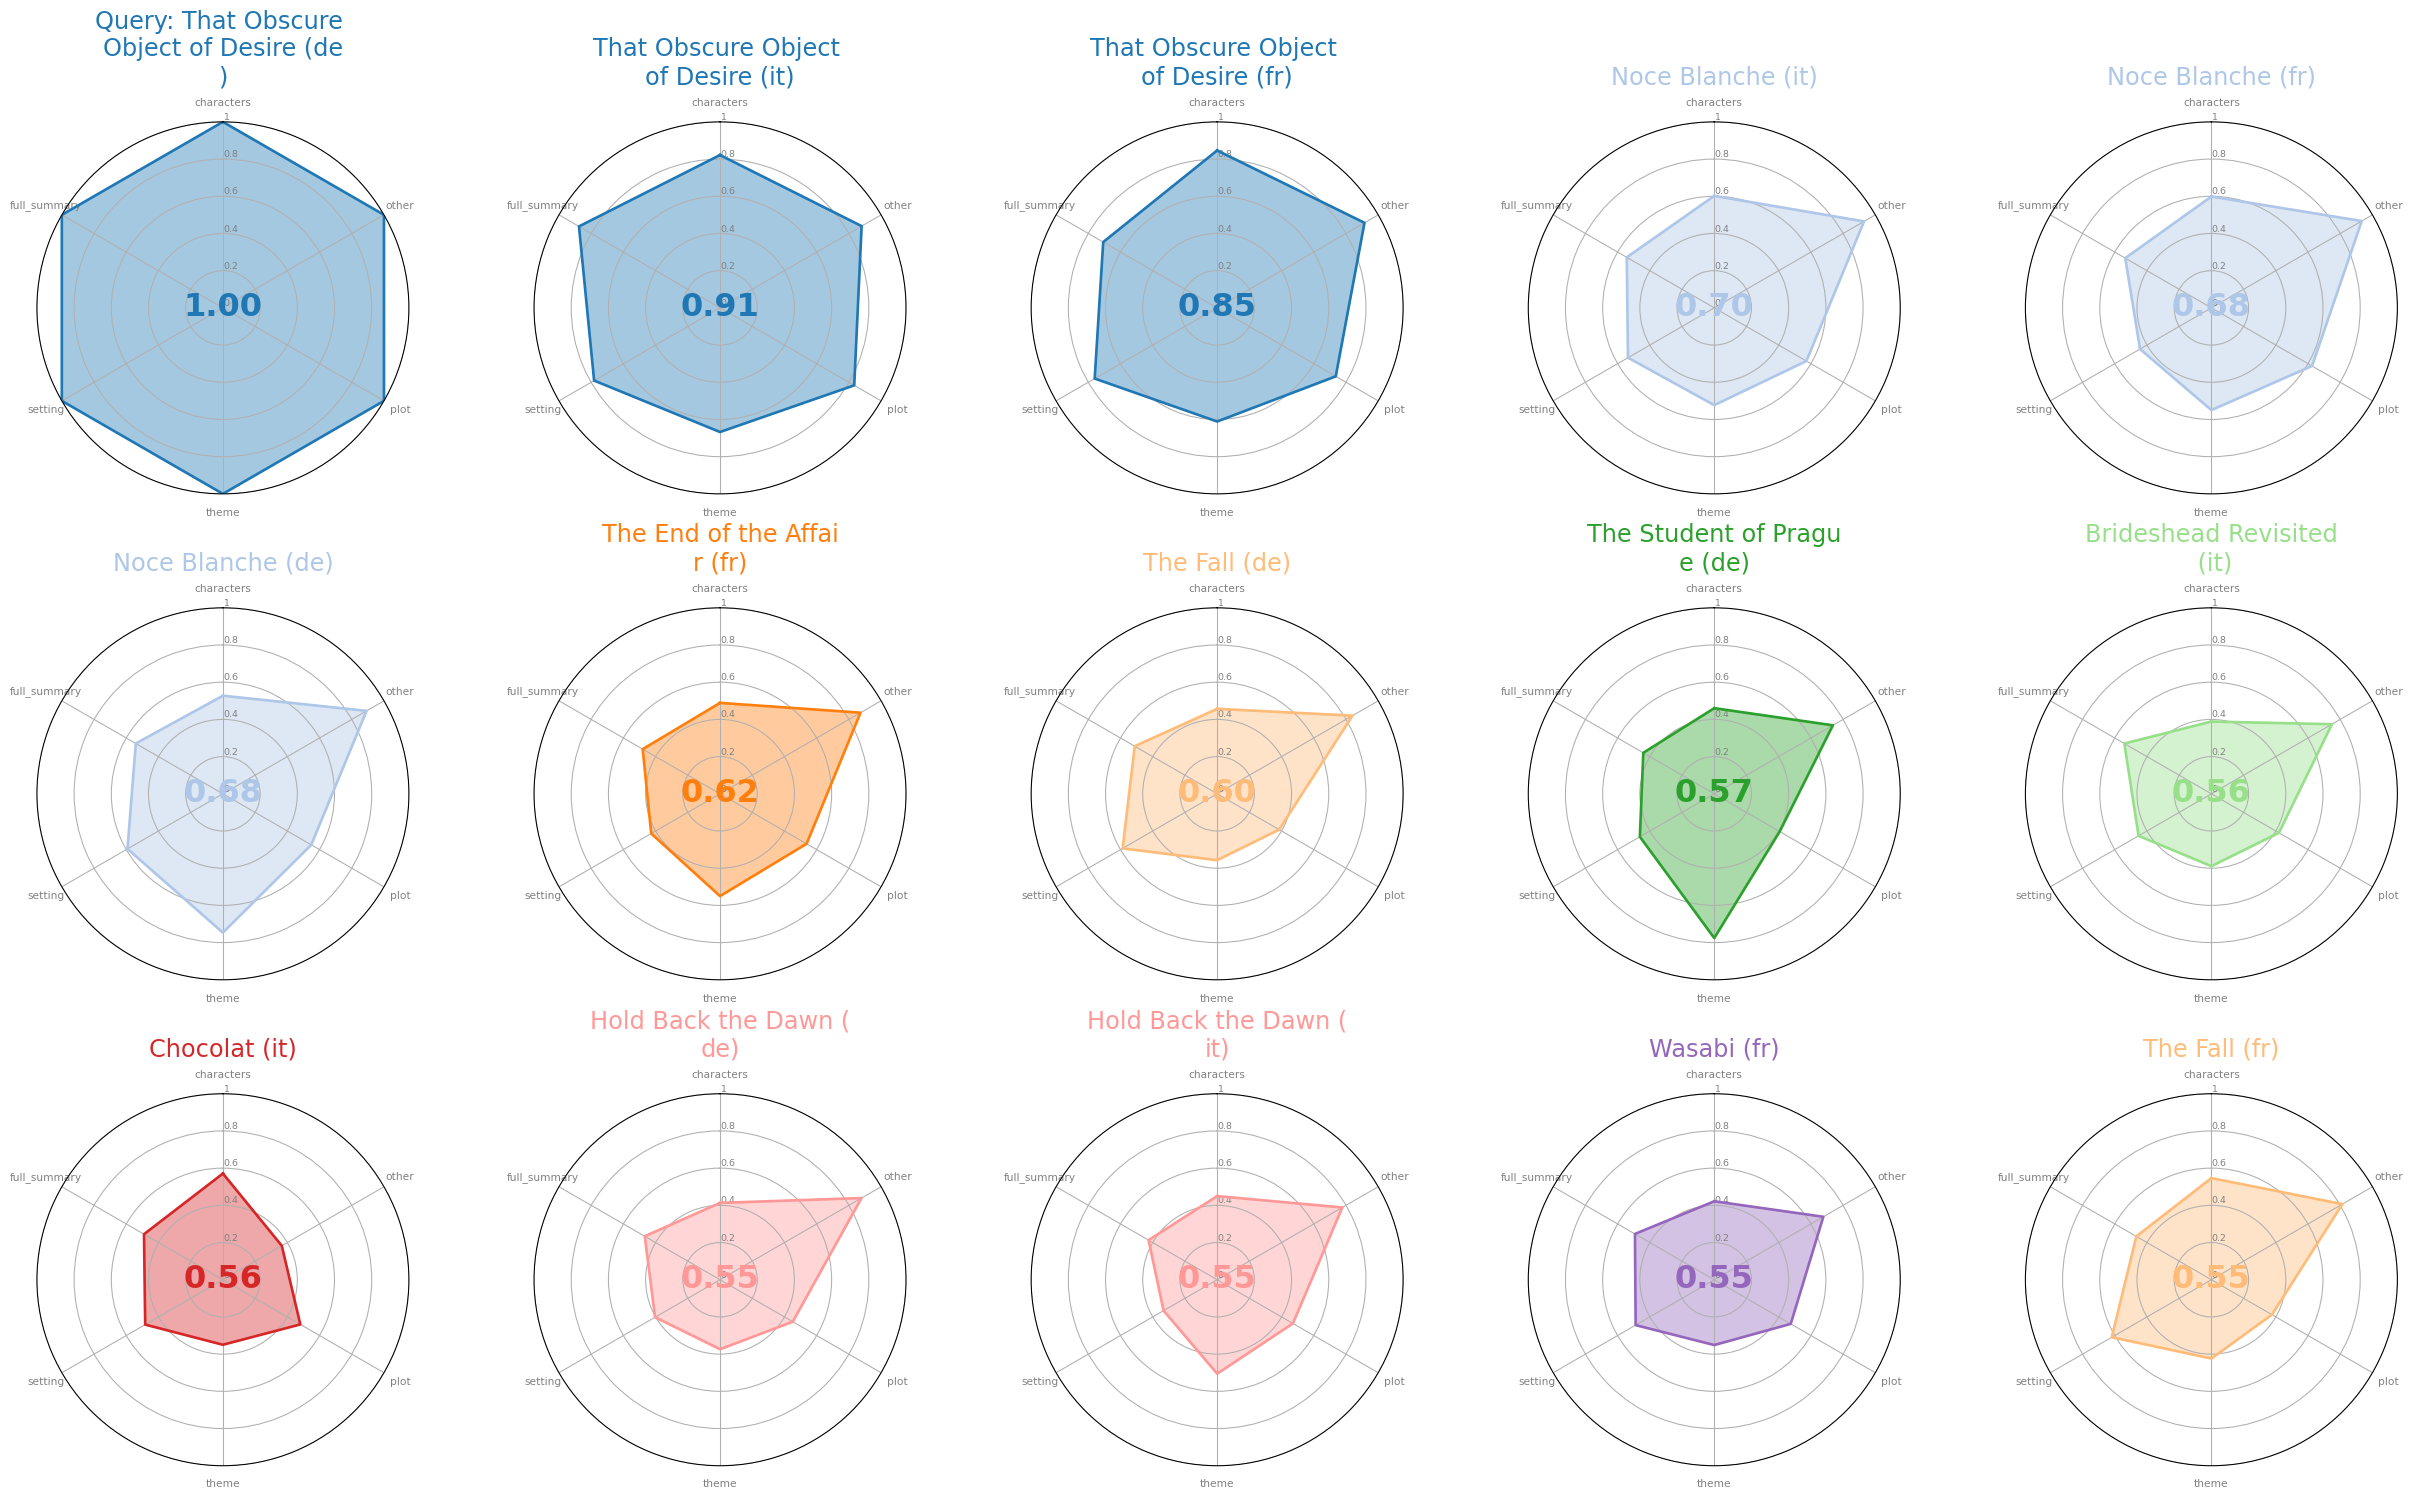

In [67]:
#visualize_similarities(df_val, model, target_index=54, top_n=14, ascending=False)

In [111]:
df[df.title == 'Shoplifters'].unpacked_summary.iloc[0]

'A poor patchwork family lives in a cramped space in the metropolis of Tokyo. Osamu has odd jobs in construction, his wife Nobuyo works in a dry-cleaning shop, Aki earns her first money as an animation girl, and the elderly Hatsue, owner of the tiny house, receives widow\'s pension. Part of the family\'s daily needs are met by shoplifting, which Osamu usually does with the help of about 10-year-old Shota. On a particularly cold winter night, they also bring home five-year-old Yuri, who is apparently regularly locked out on the balcony by her parents. Although the little one shows signs of abuse, they want to bring her back after dinner. However, a loud argument between her parents prevents her from doing so. Weeks go by without Yuri\'s parents looking for her. She quickly gets used to her new family, receives affection and love. Shota involves her in the shoplifting and, at Osamu\'s request, soon identifies her as his "sister". When the police finally come looking for her, they cut her

In [106]:
df[100:150]

Unnamed: 0  Unnamed: 0.1 wikidata_id                         title  \
100        1415          1415    Q1056225      The Last Days of Pompeii   
101        1416          1416    Q1056225      The Last Days of Pompeii   
102        1421          1421     Q105624           The Bourne Identity   
103        1422          1422     Q105624           The Bourne Identity   
104        1423          1423     Q105624           The Bourne Identity   
105        1431          1431    Q1056376                        Carmen   
106        1433          1433    Q1056376                        Carmen   
107        1505          1505    Q1057015                       Taken 2   
108        1507          1507    Q1057015                       Taken 2   
109        1508          1508    Q1057015                       Taken 2   
110        1509          1509     Q105702               Dr. Strangelove   
111        1510          1510     Q105702               Dr. Strangelove   
112        1512          1512     Q105702               Dr. Strangelove   
113        1516          1516    Q1057045               The Kite Runner   
114        1518          1518    Q1057045               The Kite Runner   
115        1536          1536    Q1057360      The Man in the Iron Mask   
116        1537          1537    Q1057360      The Man in the Iron Mask   
117        1623          1623    Q1058723             The Lady Vanishes   
118        1625          1625    Q1058723             The Lady Vanishes   
119        1626          1626  Q105883400                     The Whale   
120        1628          1628  Q105883400                     The Whale   
121        1629          1629  Q105883400                     The Whale   
122        1632          1632    Q1058952                       Scrooge   
123        1672          1672    Q1059553               Zorba the Greek   
124        1673          1673    Q1059553               Zorba the Greek   
125        1686          1686    Q1059683         The End of the Affair   
126        1820          1820    Q1062365                        Hunger   
127        1846          1846     Q106316            Dead Poets Society   
128        1848          1848     Q106316            Dead Poets Society   
129        1849          1849     Q106316            Dead Poets Society   
130        1877          1877     Q106440                    Goldfinger   
131        1907          1907    Q1064885                  Dolphin Tale   
132        1908          1908    Q1064885                  Dolphin Tale   
133        1909          1909    Q1064885                  Dolphin Tale   
134        1926          1926  Q106514711                           Men   
135        1927          1927  Q106514711                           Men   
136        1950          1950  Q106577763      Downton Abbey: A New Era   
137        1951          1951  Q106577763      Downton Abbey: A New Era   
138        1952          1952  Q106577763      Downton Abbey: A New Era   
139        2028          2028  Q106740037  Good Luck to You, Leo Grande   
140        2029          2029  Q106740037  Good Luck to You, Leo Grande   
141        2030          2030  Q106740037  Good Luck to You, Leo Grande   
142        2109          2109    Q1070275                          Fear   
143        2110          2110    Q1070275                          Fear   
144        2111          2111  Q107027721                 Bones and All   
145        2113          2113  Q107027721                 Bones and All   
146        2114          2114  Q107027721                 Bones and All   
147        2179          2179  Q107107865                  Drive My Car   
148        2180          2180  Q107107865                  Drive My Car   
149        2181          2181  Q107107865                  Drive My Car   

    language                                   unpacked_summary  \
100       de  At the Austrian premiere, the film, which (des...   
101       fr  In the time of Jesus Christ, th

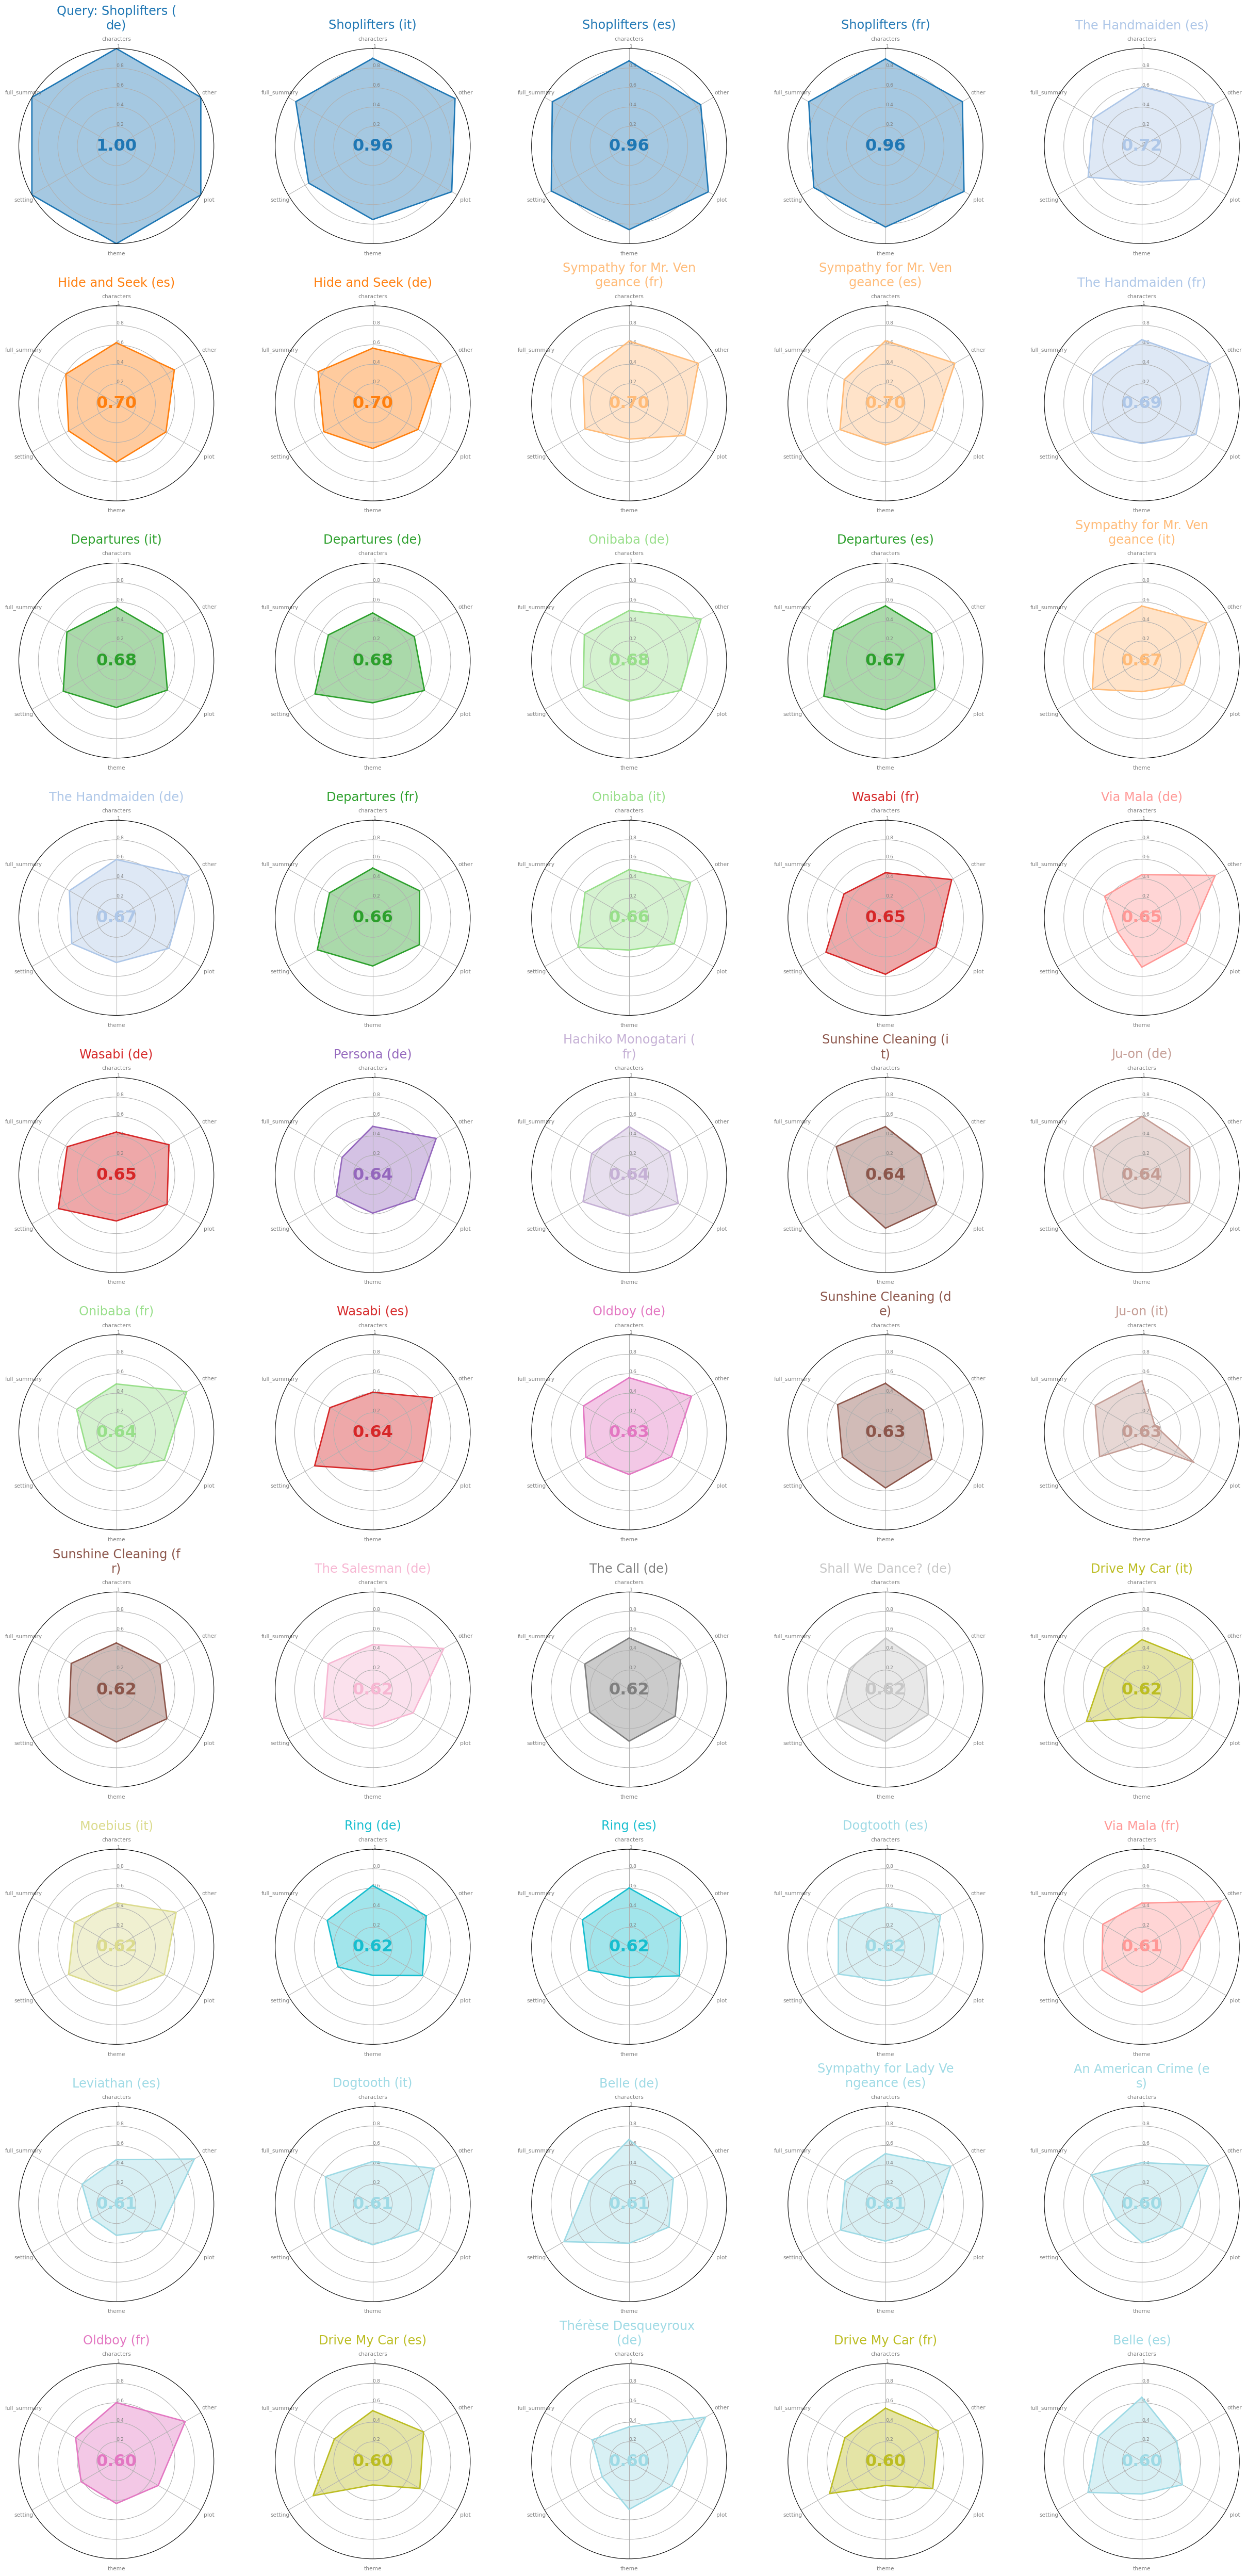

In [109]:
visualize_similarities(df, attention_model, target_index=2683, top_n=49, ascending=False)

In [ ]:
visualize_similarities(df, model, target_index=54, top_n=14, ascending=False)

In [ ]:
attention_model.print_weights = True

In [ ]:
#df,_ = embed_elements(df, model)
df = apply_attention(df, embedding_cols, attention_model)

In [ ]:
df[df.title == 'Casino Royale']

In [ ]:
visualize_similarities(df, model, target_index=54, top_n=24, ascending=False)

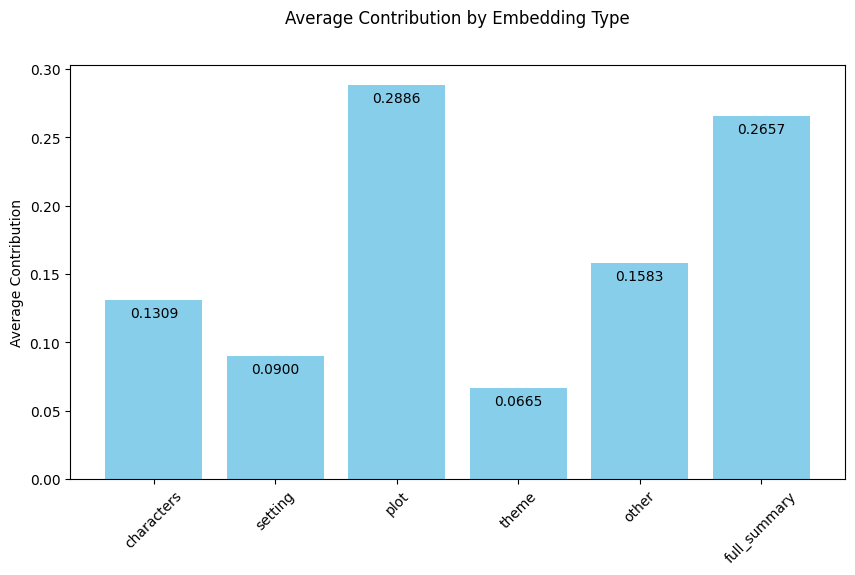

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Data
contributions = np.array([0.1309, 0.0900, 0.2886, 0.0665, 0.1583, 0.2657])
categories = ["embedding_characters", "embedding_setting", "embedding_plot", 
              "embedding_theme", "embedding_other", "embedding_full_summary"]
cleaned_labels = [label.replace("embedding_", "") for label in categories]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(cleaned_labels, contributions, color='skyblue')
plt.ylabel('Average Contribution')
plt.title('Average Contribution by Embedding Type', pad=30)  # More padding above title
plt.xticks(rotation=45)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.015, f'{height:.4f}',
             ha='center', va='bottom')

# Manually set top margin to avoid clipping
plt.subplots_adjust(top=0.8)  # Lower value means more space at top
plt.show()
